In [8]:
import sys
sys.path.append('../src')

In [9]:
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

## Record gameplay.
Call recorder.stop() to interrupt recording.

In [3]:
import gta.recording.unified
recording = gta.recording.unified.UnifiedRecorder(
    includeKeyboard=False,
    gamepadPeriod=.001, visionPeriod=.05
)
recording.start()
time.sleep(10)

In [ ]:
print('Images are ... ', end='')
while True:
    X = recording.xrecorder.results
    print('%.2fGB ' % (X.size * X.dtype.itemsize / 1024 / 1024 / 1024,), end='')
    time.sleep(4)

In [5]:
recording.stop()

In [6]:
X = recording.xrecorder.results
print('%.2fGB ' % (X.size * X.dtype.itemsize / 1024 / 1024 / 1024,), end='')
del X

9.27GB 

In [11]:
saved = recording.save(compressed=False)

Saving to C:\Users\tsbertalan\data\UnifiedRecorder-1509210169.3261402.npz ... Generated XYT in 23.6 seconds.
done (1.69e+03 s).


In [12]:
1.69e3/60

28.166666666666668

In [21]:
saved['Y'].size / 1024

59.4921875

Takes about 4 times as long if compression is indicated.

## Load and use data.

In [2]:
import sys
sys.path.append('../src')

In [3]:
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import time
import tqdm
%matplotlib inline

In [4]:
import gta.utils, os

In [5]:
fpath = os.path.join(gta.utils.home, 'data', 'UnifiedRecorder-1509207348.4853144.npz')

In [ ]:
keepEids = [0, 2, 5]

In [19]:
%%time
try:
    saved.keys()
except NameError:
    # Data not loaded.
    saved = np.load(fpath)
DT = np.diff(saved['T'])
X = saved['X'][1:]
# Only keep the first 6 features (gamepad; leave out buttons)
Y = saved['Y'][1:][:, keepEids]

Normalize the data.

In [21]:
# data is too big for this
# X = (X.astype('float32') - 128) / 256

In [22]:
def normalize(mat):
    return (mat.astype('float32') - 127.5) / 255

What does the distribution of outputs look like?

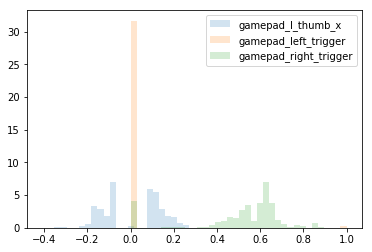

In [23]:
fig, ax = plt.subplots()
for eid in keepEids:
    label = gta.eventIDs.eids2names[eid]
    ax.hist(Y[:, eid], label=label, alpha=.2, normed=True, bins=32)
ax.legend();

In [24]:
Y = Y[:, keepEids]
Y.shape

(3045, 3)

In [25]:
splits = int(len(DT) * .8), int(len(DT) * .9)

def s(a, b):
    return X[a:b], Y[a:b], DT[a:b]

X_train, Y_train, DT_train = s(0, splits[0])
X_test, Y_test, DT_test = s(splits[0], splits[1])
X_valid, Y_valid, DT_valid = s(splits[1], -1)
X_train.shape, X_test.shape, X_valid.shape

((2436, 797, 1366, 3), (304, 797, 1366, 3), (304, 797, 1366, 3))

In [26]:
n_train = len(DT_train)
n_test = len(DT_test)
n_valid = len(DT_valid)
n_train, n_test, n_valid

(2436, 304, 304)

In [27]:
image_shape = X_train.shape[1:]

In [28]:
import tensorflow as tf
import gta.nn
reload(gta.nn);

In [29]:
x = tf.placeholder(tf.float32, (None, *image_shape), name='images')
y = tf.placeholder(tf.float32, (None, 3), name='gamepad_axes')

In [30]:
class Arch(gta.nn.ConvNet):
    
    def __call__(self, x, name='predictions'):
        td = self._addConv2d
        fc = self._addFc
        #self.keep_prob = tf.placeholder_with_default(.5, shape=())
        
        x = td(x, (8, 8, self.c, 12), padding='SAME', pooling=False)
        x = td(x, (8, 8, int(x.shape[-1]), 12), padding='VALID')
        #x = tf.nn.dropout(x, self.keep_prob)
        
        x = td(x, (3, 3, int(x.shape[-1]), 16), padding='SAME')#, pooling=False)
        x = td(x, (3, 3, int(x.shape[-1]), 16), padding='VALID')
        
        x = td(x, (3, 3, int(x.shape[-1]), 32), padding='SAME')#, pooling=False)
        x = td(x, (3, 3, int(x.shape[-1]), 32), padding='VALID')
        
        x = td(x, (3, 3, int(x.shape[-1]), 64), padding='SAME')#, pooling=False)
        x = td(x, (3, 3, int(x.shape[-1]), 64), padding='VALID')
        
        x = tf.contrib.layers.flatten(x)
        
        x = fc(x, (int(x.shape[-1]), 32))
        x = fc(x, (int(x.shape[-1]), Y.shape[1]), name=name)
        
        return x

net = Arch(c=image_shape[-1])
z = net(x)
y, z

(<tf.Tensor 'gamepad_axes:0' shape=(?, 3) dtype=float32>,
 <tf.Tensor 'predictions:0' shape=(?, 3) dtype=float32>)

## Train

In [31]:
loss = tf.losses.mean_squared_error(y, z)
learning_rate = .001
training_operation = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [13]:
import gta.utils; reload(gta.utils);

In [14]:
with gta.utils.timeit('thing'):
    pass

thing ... 0.0 sec elapsed


In [32]:
EPOCHS = 150
BATCH_SIZE = 128

In [37]:
def evaluate(X_data, y_data, sess=None, extraFeedDict={}):
    if hasattr(net, 'keep_prob'):
        extraFeedDict.setdefault(net.keep_prob, 1.0)
    num_examples = len(X_data)
    total_accuracy = 0
    if sess is None: sess = tf.get_default_session()
        
    num = 0
    den = 0
    
    for offset in tqdm.tqdm(range(0, num_examples, BATCH_SIZE)):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        fd = {x: normalize(batch_x), y: batch_y}
        fd.update(extraFeedDict)
        run = lambda inp: sess.run(inp, feed_dict=fd)
        
        num += run(tf.reduce_sum((y - z) ** 2))
        den += len(batch_x)
        
    return num / den

Evaluate the untrained network.

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(evaluate(X_valid, Y_valid))